In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import cross_val_score

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler

import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
print(test.head())

train.columns

print("SPLITTER")

print(train.describe())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  
SPLITTER
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.0000

In [5]:
print(train['Transported'].dtype)



bool


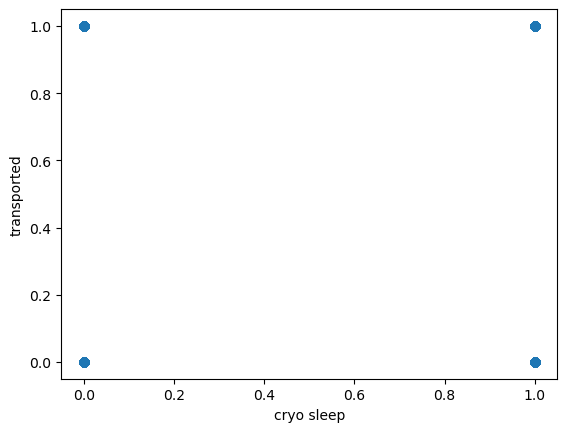

In [6]:
#see if correlation between sleeping and being transported


plt.scatter(train['CryoSleep'], train['Transported'])

plt.xlabel("cryo sleep")
plt.ylabel("transported")

plt.show()

#this shows no correlation whatsoever

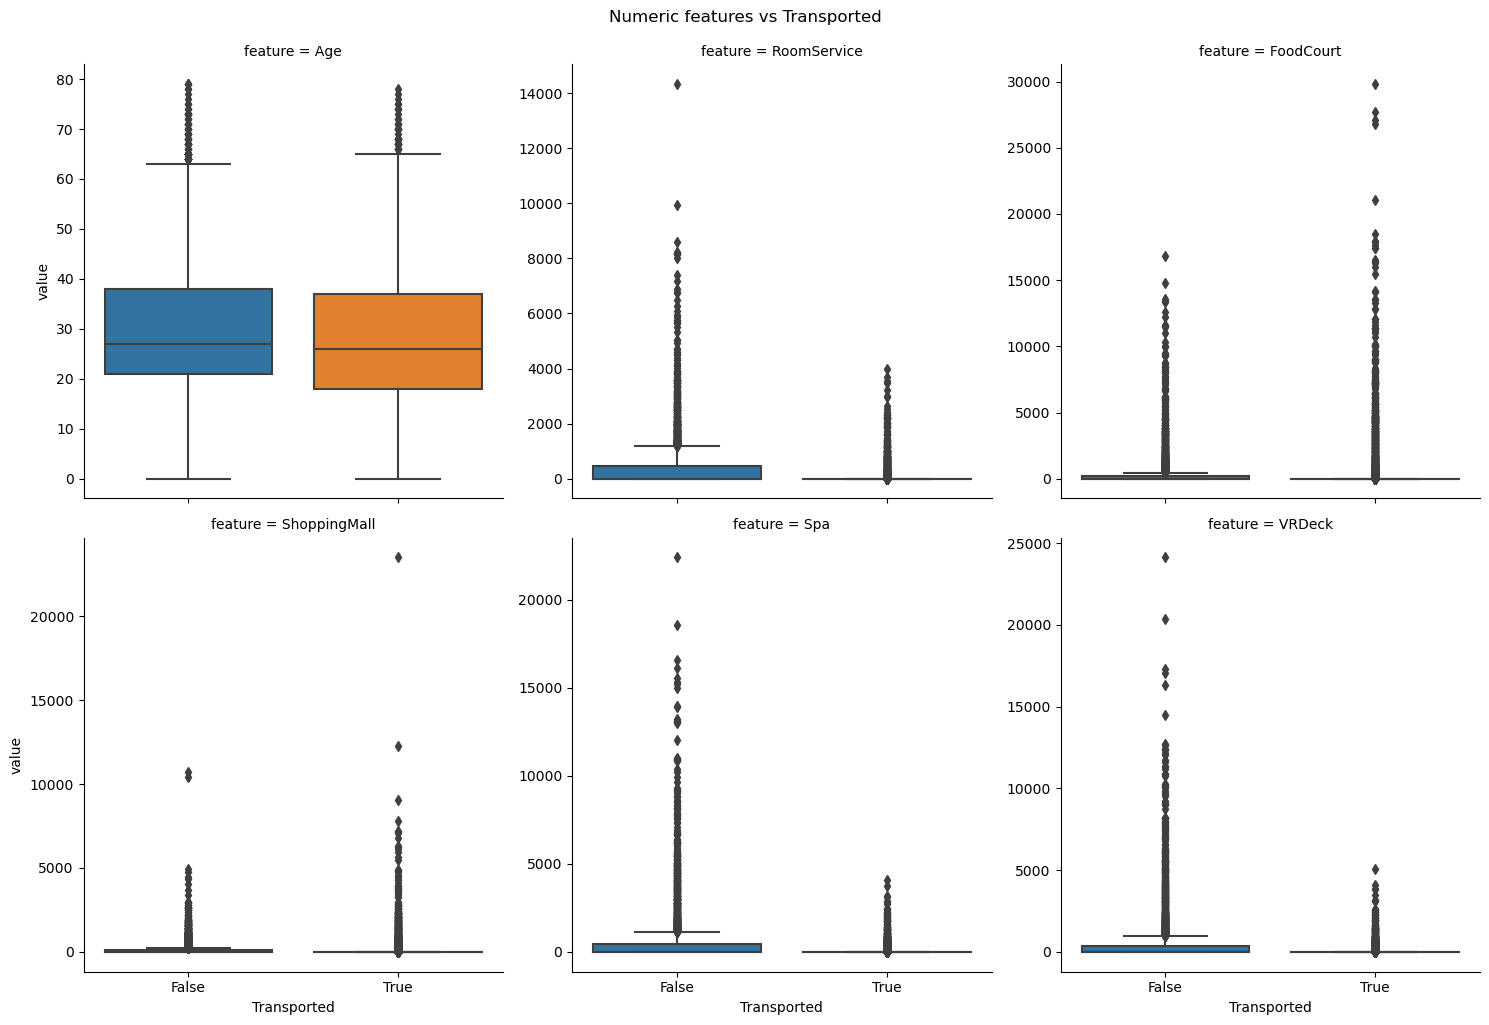

In [7]:
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']  # adjust to your columns

# Melt into long format so seaborn can facet by feature name
long_num = train.melt(
    id_vars='Transported',
    value_vars=num_cols,
    var_name='feature',
    value_name='value'
)

g = sns.catplot(
    data=long_num,
    x='Transported',
    y='value',
    col='feature',
    col_wrap=3,        # how many plots per row
    kind='box',        # can change to 'violin' if you like
    sharey=False       # each feature gets its own y-scale
)

g.fig.suptitle('Numeric features vs Transported', y=1.02)
plt.show()


In [8]:
print(train['Destination'].unique())

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


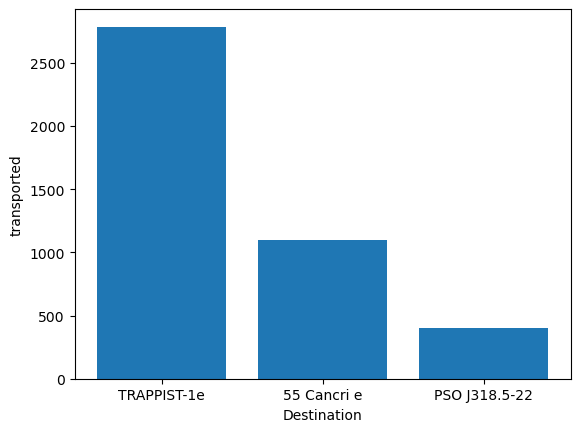

In [9]:
#see if correlation between destination and being transported. The thought is that some passengers may have been dropped off, therefore they cannot be transported


#count how many going to that desintation got transported

df_transported = train[train['Transported'] == True]

counts = df_transported['Destination'].value_counts()

plt.figure()
plt.bar(counts.index, counts.values)

#plt.bar(train['Destination'], train['Transported'])

plt.xlabel("Destination")
plt.ylabel("transported")

plt.show()


#very nice, most of trappist-1e got transported, will include in model

In [10]:
impute_mean = SimpleImputer(strategy = 'mean')
        
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Fit on numeric columns and transform

#bad assumption, getting mean of all columns and then imputing that mean into all missing values of any numerics
#need to get mean of each numeric column and impute that into its appropriate column



train[num_cols] = impute_mean.fit_transform(train[num_cols])

In [11]:
#change to categorical types instead of objects
cat_cols = train.select_dtypes(include=['object']).columns

train[cat_cols] = train[cat_cols].astype('category')

train.dtypes


PassengerId     category
HomePlanet      category
CryoSleep       category
Cabin           category
Destination     category
Age              float64
VIP             category
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name            category
Transported         bool
dtype: object

In [12]:


X = train.drop(columns=['Transported'], errors='ignore')
y = train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [13]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=0,
    enable_categorical=True,
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, random_state=0, ...)

In [14]:
#test on seen data
xgb.score(X_train, y_train)

0.8432556801840667

In [15]:
#test on unforseen data
xgb.score(X_test, y_test)

0.79700977573318

In [16]:
cv = StratifiedKFold(
    n_splits=5,       # 5-fold CV
    shuffle=True,     # shuffle before splitting
    random_state=42   # for reproducibility
)

scores = cross_val_score(
    xgb,
    X, y,
    cv=cv,              # our StratifiedKFold object
    scoring='accuracy'  # or 'f1', 'roc_auc', etc.
)

print("scores mean: " + str(scores.mean()))
print("scores: " + str(scores))



scores mean: 0.7943167342844154
scores: [0.80621047 0.78205865 0.79930995 0.8009206  0.783084  ]


In [17]:
importances = xgb.feature_importances_
#print("Feature Importances (Gain):", importances)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

importance_df = importance_df.sort_values(by='importance', ascending=False)
print(importance_df)

         feature  importance
2      CryoSleep    0.507073
1     HomePlanet    0.101871
10           Spa    0.064987
11        VRDeck    0.064401
7    RoomService    0.060951
8      FoodCourt    0.040023
9   ShoppingMall    0.031912
4    Destination    0.025868
5            Age    0.023758
3          Cabin    0.023685
6            VIP    0.021876
0    PassengerId    0.018952
12          Name    0.014643


In [18]:
# base_estimator = DecisionTreeClassifier(max_depth=1)

# adaboost_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
# adaboost_model.fit(X_train, y_train)

In [19]:
# print( "this is train score: " + str(adaboost_model.score(X_train, y_train)))
# print( "this is test score: " + str(adaboost_model.score(X_test, y_test)))

In [20]:
# gb = GradientBoostingClassifier(
#     random_state=0,
#     n_estimators=100,
#     learning_rate=0.2,
#     max_depth=3
# )

# gb.fit(X_train, y_train)

# print("this is the train score: " + str(gb.score(X_train, y_train)))
# print("this is the test score: " + str(gb.score(X_test, y_test)))

In [21]:
print(train.columns)

#cols_to_exclude = [
#     'PassengerId',
#     'Name',
#     'HomePlanet',  # original column
#     'CryoSleep',
#     'VIP',
#     'Age',
#     'RoomService',
#     'FoodCourt',
#     'ShoppingMall',
#     'Spa',
#     'VRDeck',
#     'Transported'
# ]


cols_to_exclude = [
    'remainder__PassengerId',
    'remainder__Name',
    'remainder__Transported',
    'remainder__VIP',
    'CryoSleep'
]

#imput mean values for numerics
impute_mean = SimpleImputer(strategy = 'mean')
        
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Fit on numeric columns and transform

#bad assumption, getting mean of all columns and then imputing that mean into all missing values of any numerics
#need to get mean of each numeric column and impute that into its appropriate column



train[num_cols] = impute_mean.fit_transform(train[num_cols])

train_new = train.copy()

train_new.head()

#scale numerics
scaler = StandardScaler()

train[num_cols] = scaler.fit_transform(train[num_cols])
#impute_mean.fit_transform(train)

#train = train.drop(columns = cols_to_exclude)

num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

X_num = train[num_cols]
y = train['Transported']

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [22]:
ohe = OneHotEncoder(sparse_output = False)
ct = make_column_transformer(
    (ohe, ['HomePlanet', 'Cabin', 'Destination', 'CryoSleep', 'VIP']),
    remainder = 'passthrough'
)

ct.set_output(transform = "pandas")

df_pandas = ct.fit_transform(train)
df_pandas
train = ct.fit_transform(train)


In [23]:
#below are what will the features will be for the model
print(train.columns)


#train = pd.get_dummies(train, columns=['Cabin', 'Destination'])
#below is for excluding cabin
# train = pd.get_dummies(train, columns=['Destination', 'Cabin', 'HomePlanet'])
# print(train.columns)

X = train.drop(columns=cols_to_exclude, errors='ignore')
y = train['remainder__Transported']



Index(['onehotencoder__HomePlanet_Earth', 'onehotencoder__HomePlanet_Europa',
       'onehotencoder__HomePlanet_Mars', 'onehotencoder__HomePlanet_nan',
       'onehotencoder__Cabin_A/0/P', 'onehotencoder__Cabin_A/0/S',
       'onehotencoder__Cabin_A/1/S', 'onehotencoder__Cabin_A/10/P',
       'onehotencoder__Cabin_A/10/S', 'onehotencoder__Cabin_A/100/S',
       ...
       'onehotencoder__VIP_nan', 'remainder__PassengerId', 'remainder__Age',
       'remainder__RoomService', 'remainder__FoodCourt',
       'remainder__ShoppingMall', 'remainder__Spa', 'remainder__VRDeck',
       'remainder__Name', 'remainder__Transported'],
      dtype='object', length=6584)


In [24]:
#split and train data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [25]:


xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=0,
    enable_categorical=True,
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, random_state=0, ...)

In [26]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=0,
    n_jobs=-1
)



In [27]:
#get the accuracy for already trained data

rf.fit(X_train, y_train)

rf.score(X_train, y_train)



0.7490652861662352

In [28]:
#get accuracy for untrained data
rf.score(X_test, y_test)


0.7320299022426682

In [29]:
# k = 5  # 5-fold CV, change to 10 if you want

# scores = cross_val_score(
#     rf,       # your model (can also use nb, etc.)
#     X, y,
#     cv=k,     # number of folds
#     scoring='accuracy'
# )

# print("CV scores for each fold:", scores)
# print("Mean CV accuracy:", scores.mean())
# print("Std dev:", scores.std())

In [30]:
nb = BernoulliNB() 

nb.fit(X_train, y_train)

BernoulliNB()

In [31]:
#get accuracy score for train
print("Train accuracy:", rf.score(X_train, y_train))
print("Test accuracy:",  rf.score(X_test, y_test))

nb.score(X_train, y_train)

Train accuracy: 0.7490652861662352
Test accuracy: 0.7320299022426682


0.772073626689675

In [32]:
#get accuracy score for test
nb.score(X_test, y_test)

0.7418056354226567

In [33]:
# scores = cross_val_score(
#     nb,       # your model (can also use nb, etc.)
#     X, y,
#     cv=k,     # number of folds
#     scoring='accuracy'
# )

# print("CV scores for each fold:", scores)
# print("Mean CV accuracy:", scores.mean())
# print("Std dev:", scores.std())

In [34]:
#now we only want passenger id and cabin



In [35]:

#get rid of everything before and including the underscore
# keep only the part after the underscore
train_new['PassengerNumber'] = train_new['PassengerId'].str.split('_').str[1]
train_new['PassengerGroup'] = train_new['PassengerId'].str.split('_').str[0]
train.shape

(8693, 6584)

In [36]:
train_new.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerNumber,PassengerGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,01,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,01,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,01,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,02,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,01,0004


In [37]:
train_new.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerNumber', 'PassengerGroup'],
      dtype='object')

In [38]:
# train_new.drop(['HomePlanet','CryoSleep','Destination',
#                'Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Name','PassengerId'])

train_new[num_cols] = impute_mean.fit_transform(train_new[num_cols])

train_new.head()

train_new.isna().sum()



impute_cat = SimpleImputer(strategy='most_frequent')

cat_cols = train_new.select_dtypes(include=['object']).columns

train_new[cat_cols] = impute_cat.fit_transform(train_new[cat_cols])

In [39]:
ohe = OneHotEncoder(sparse_output=False)
ct = make_column_transformer(
    (ohe, ['Cabin', 'Destination']),
    remainder='passthrough'
)

ct.set_output(transform="pandas")

#  define X and y *before* transforming
# X = train_new.drop(columns=['CryoSleep',
#        'Name','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
#         'Transported'])
X = train_new.drop(columns=['Name', 'Transported','HomePlanet','PassengerId'])
y = train_new['Transported']




#  transform X, not train_new
X = ct.fit_transform(X)
# scaler = StandardScaler()

# X= scaler.fit_transform(train[num_cols])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [41]:
X_train.head()

,onehotencoder__Cabin_A/0/P,onehotencoder__Cabin_A/0/S,onehotencoder__Cabin_A/1/S,onehotencoder__Cabin_A/10/P,onehotencoder__Cabin_A/10/S,onehotencoder__Cabin_A/100/S,onehotencoder__Cabin_A/101/S,onehotencoder__Cabin_A/102/S,onehotencoder__Cabin_A/103/S,onehotencoder__Cabin_A/104/S,...,remainder__CryoSleep,remainder__Age,remainder__VIP,remainder__RoomService,remainder__FoodCourt,remainder__ShoppingMall,remainder__Spa,remainder__VRDeck,remainder__PassengerNumber,remainder__PassengerGroup
5776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,True,39.0,False,0.000000,0.0,0.0,0.0,0.0,02,6118
220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,43.0,False,224.687617,888.0,0.0,0.0,0.0,01,0234
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,24.0,False,19.000000,676.0,0.0,26.0,0.0,01,2580
5876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,16.0,False,0.000000,0.0,60.0,0.0,1963.0,01,6224
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,21.0,False,367.000000,281.0,0.0,0.0,146.0,01,0213


In [42]:
# rf = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=20,
#     random_state=0,
#     n_jobs=-1
# )

In [43]:
#get the accuracy for already trained data

# rf.fit(X_train, y_train)

# rf.score(X_train, y_train)



In [44]:
#get accuracy for untrained data
#rf.score(X_test, y_test)

In [45]:
nb.fit(X_train, y_train)

nb.score(X_train, y_train)


ValueError: Input X contains NaN.
BernoulliNB does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
nb.score(X_test, y_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)  # K = 5
knn.fit(X_train, y_train)


#print("Validation accuracy:", knn.score(X_valid, y_valid))

In [ ]:
knn.score(X_train, y_train)

In [ ]:
knn.score(X_test, y_test)

In [ ]:
problem_cols = [
    'remainder__CryoSleep',
    'remainder__VIP',
    'remainder__PassengerNumber',
    'remainder__PassengerGroup'
]

for col in problem_cols:
    X[col] = X[col].astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=0,
    enable_categorical=True,
)

xgb.fit(X_train, y_train)

In [ ]:
xgb.score(X_train, y_train)

In [ ]:
xgb.score(X_test, y_test)

In [ ]:
gb = GradientBoostingClassifier(
    random_state=0,
    n_estimators=100,
    learning_rate=0.2,
    max_depth=3
)

gb.fit(X_train, y_train)


In [ ]:
gb.score(X_train, y_train)

In [ ]:
gb.score(X_test, y_test)

In [ ]:
# scores = cross_val_score(gb, X, y, cv=5)  # 5-fold CV
# print("CV scores:", scores)
# print("Mean:", scores.mean(), "±", scores.std())

In [ ]:
importances = pd.Series(gb.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(50))

In [ ]:
gb2 = GradientBoostingClassifier(
    random_state=0,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3
)

gb2.fit(X_train, y_train)
print("gb2 accuracy:", gb2.score(X_train, y_train))
print("gb2 accuracy:", gb2.score(X_test, y_test))

In [ ]:
# #importance rating below

# remainder__CryoSleep                        0.426765
# remainder__Spa                              0.120181
# remainder__RoomService                      0.107682
# remainder__VRDeck                           0.102293

In [ ]:
train_new.head()
train_new.columns

In [ ]:
# X = train_new.drop(columns = ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Age',
#        'VIP', 'FoodCourt', 'ShoppingMall',
#        'Name', 'Transported', 'PassengerNumber', 'PassengerGroup'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
X_train.head()

In [ ]:
# list_scores_estimators = []

# n_estimators_max = 300
# learning_rate_max = 100
# max_depth = 10
# #n_estimator changes below
# list_pos = 0
# for i in range(10, n_estimators_max, 10):
#     #change the values
#     gb2 = GradientBoostingClassifier(
#         random_state=0, #don't touch
#         n_estimators=i, #touch
#         learning_rate=0.25, #touch
#         max_depth=8 #touch
#     )
#     gb2.fit(X_train, y_train)
#     gb2_score = gb2.score(X_test, y_test)
#     list_scores_estimators.append(gb2_score)
#     list_pos += 1

#print(max(list_scores))






# gb2.fit(X_train, y_train)
# print("gb2 accuracy:", gb2.score(X_train, y_train))
# print("gb2 accuracy:", gb2.score(X_test, y_test))

In [ ]:
# print(max(list_scores))
# max_estimators_score = max(list_scores_estimators)
# max_pos = list_scores_estimators.index(max_estimators_score)
# estimators_optimal = max_pos*10 + 10

In [ ]:
# list_pos = 0
# list_scores_learning = []
# for i in range(5, learning_rate_max, 5):
#     i = i /100
#     #change the values
#     gb2 = GradientBoostingClassifier(
#         random_state=0, #don't touch
#         n_estimators=300, #touch
#         learning_rate=i, #touch
#         max_depth=8 #touch
#     )
#     gb2.fit(X_train, y_train)
#     gb2_score = gb2.score(X_test, y_test)
#     list_scores_learning.append(gb2_score)
#     list_pos += 1

In [ ]:
# print(max(list_scores_learning))
# max_learning_score = max(list_scores_learning)
# max_pos = list_scores_learning.index(max_learning_score)
# learning_optimal = max_pos*0.05 + 0.05

In [ ]:
# list_pos = 0
# list_scores_depth = []
# for i in range(1, max_depth, 1):
#     #change the values
#     gb2 = GradientBoostingClassifier(
#         random_state=0, #don't touch
#         n_estimators=300, #touch
#         learning_rate=0.05, #touch
#         max_depth=i #touch
#     )
#     gb2.fit(X_train, y_train)
#     gb2_score = gb2.score(X_test, y_test)
#     list_scores_depth.append(gb2_score)
#     list_pos += 1

In [ ]:
# print(max(list_scores_depth))
# max_depth_score = max(list_scores_depth)
# max_pos = list_scores_depth.index(max_depth_score)
# depth_optimal = max_pos*1 + 1

In [ ]:
# gb_optimal = GradientBoostingClassifier(
#         random_state=0, #don't touch
#         n_estimators=estimators_optimal, #touch
#         learning_rate=learning_optimal, #touch
#         max_depth=depth_optimal #touch
#     )
# gb_optimal.fit(X_train, y_train)
# gb_optimal_score = gb2.score(X_test, y_test)

In [ ]:
# print(gb_optimal_score)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=0,
    n_jobs=-1
)
rf.fit(X_train, y_train)

In [ ]:
#seen data score
rf.score(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

In [ ]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(50))

In [ ]:
nb.fit(X_train, y_train)

nb.score(X_train, y_train)



In [ ]:
nb.score(X_test, y_test)

In [ ]:
RocCurveDisplay.from_estimator(gb2, X_test, y_test)

plt.title("ROC curve – GradientBoosting")
plt.show()

In [ ]:
# scores = cross_val_score(gb2, X, y, cv=5)
# print(scores, scores.mean(), scores.std())

In [ ]:
y_pred = gb2.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# k_folds = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation
# scores = cross_val_score(gb2, X, y, cv=k_folds)
# print("Cross Validation Scores:", scores)
# print("Average CV Score:", scores.mean())
# print("Standard Deviation of CV Scores:", scores.std()) # Useful for understanding variability
    

In [ ]:
cv = StratifiedKFold(
    n_splits=5,       # 5-fold CV
    shuffle=True,     # shuffle before splitting
    random_state=42   # for reproducibility
)

In [ ]:
cv = StratifiedKFold(
    n_splits=5,       # 5-fold CV
    shuffle=True,     # shuffle before splitting
    random_state=42   # for reproducibility
)

scores = cross_val_score(
    gb2,
    X, y,
    cv=cv,              # our StratifiedKFold object
    scoring='accuracy'  # or 'f1', 'roc_auc', etc.
)

scores.mean()
scores

In [ ]:
scores.mean()
scores

In [ ]:
    # Example with RBF kernel
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

    # Example with linear kernel
    # svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [ ]:
svm_model.fit(X_train, y_train)

In [ ]:
svm_model.score(X_train, y_train)

In [ ]:
svm_model.score(X_test, y_test)

In [ ]:
svm = SVC()
grid = GridSearchCV(
    estimator=svm,
    #param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

In [ ]:
ohe = OneHotEncoder(sparse_output=False)
ct = make_column_transformer(
    (ohe, ['Cabin', 'Destination']),
    remainder='passthrough'
)

ct.set_output(transform="pandas")

#  define X and y *before* transforming
# X = train_new.drop(columns=['CryoSleep',
#        'Name','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
#         'Transported'])
X = test.drop(columns=['Name', 'Transported','HomePlanet','PassengerId'])
y = test['Transported']




#  transform X, not train_new
X = ct.fit_transform(X)
# scaler = StandardScaler()

# X= scaler.fit_transform(train[num_cols])

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_model.fit(X_train, y_train)

In [ ]:
print( "this is train score: " + str(adaboost_model.score(X_train, y_train)))
print( "this is test score: " + str(adaboost_model.score(X_test, y_test)))